In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
import eulerangles
import dynamotable
from biopandas.pdb import PandasPdb
import itertools

In [2]:
# import dynamo TBL files and convert to numpy arrays for positions and Euler angles
# 'pixelsize' is the pixel size in Angstroms
def importTBL(tblfile, pixelsize):
    df0 = dynamotable.read(tblfile)
    # grab the columns for the rubisco index, carboxysome index, rubisco positions, and rubisco euler angles
    df = df0[["tag","reg","x","y","z", "tdrot","tilt", "narot"]].copy()
    df.loc[:,["x","y","z"]] = df[["x","y","z"]]*pixelsize
    df.rename(columns={"tag": "runum",
                       "reg": "CBnum",
                       "tdrot": "eulZ",
                       "tilt": "eulX",
                       "narot": "eulZp"
                      }, inplace=True)
    
    return df

In [3]:
df = importTBL("rubisco_table.tbl", 2.14)

In [4]:
df.head(3)

,runum,CBnum,x,y,z,eulZ,eulX,eulZp
0,1,1,1591.4966,3695.566,1299.6220,89.645,66.6170,110.2900
1,2,1,1677.7172,3460.808,1313.4464,65.749,12.7590,37.0750
2,3,1,1766.6342,3537.848,1268.7632,-24.012,8.3148,1.0002


In [5]:
# AlphaFold2 was used to generate an all-atom structure for H. neapolitanus rubisco LS unit in multimer mode.
# This was done to include a plausible model of all missing residues, e.g. at termini and unstructured loops, and to
# explicitly included hydrogen coordinates.
#The model was then aligned to LS asymmetric unit in PDB 1SVD.
# load the coordinates for the AF2 structure aligned to 1SVD
ruaf2 = PandasPdb().read_pdb("ru_af2.pdb")

In [6]:
# phenix.dock_in_map was used to find the transformation of the 1SVD holoenzyme into the subtomogram template map

# find the rotation about the z-axis that transforms from the symmetric frame (ie. 1SVD) to the subtomogram frame
# subsequent calculations use Euler angle transformations so we need the Euler angles to match atomic coordinates
# to the template.
# Unfortunately there is some numerical instability with the Z-axis already aligned so need a manual sweep.
# rotation matrix
obsrotmat = np.array([[0.7621,-0.6475,-0.0001],[0.6475,0.7621,0],[0.0001,0,1]])

# iterate over Z-axis rotations and find the rotation that minimizes the variance between the rotation matrices.
numpnts = 10001
matsum = np.zeros((numpnts, 2))
for inda, ang in enumerate(np.linspace(0,90,numpnts)):
    testmat = eulerangles.euler2matrix([ang,0,0], axes='ZXZ', intrinsic=False, right_handed_rotation=True)
    matsum[inda,:]= [ang,np.sum((obsrotmat - testmat)**2)]


zsubtomo = matsum[np.argmin(matsum[:,1]),0]
print("Euler angle match for Z: %f" % zsubtomo)

Euler angle match for Z: 40.356000


In [7]:
# compute the rotation matrices to align the orientation to the subtomogram and create the D4 complex
# this generates all combinations of euler angles align to the template and make all 8 LS units
d4eulers = list(itertools.product(np.array([0,90,180,270]) + zsubtomo,[0,180]))
# this calculates the set of rotation matrices corresponding to the above euler angle orientations
d4matrices = [eulerangles.euler2matrix([e[0],e[1],0], axes='ZXZ', intrinsic=False, right_handed_rotation=True)\
              for e in d4eulers]

In [8]:
# create a dictionary from "centralRubiscos" a list of all rubisco indices that are found in the dense
# lattice cores
centru_ind = np.genfromtxt("centralRubiscos.txt", dtype=int)
# get the carboxysome indices for each of the central rubiscos
cbinds = np.array([df["CBnum"][df["runum"] == ci].to_numpy() for ci in centru_ind]).flatten()
# create a dictionary that maps the rubisco index to the corresponding carboxysome index
centru_dict = dict(zip(centru_ind, cbinds))

In [9]:
# return a dataframe with the rubiscos within a particular radius of the center rubisco
def rubiscos_in_rad(df0, ruind0, centru_dict0, maxrad):
    # get the xyz coordinates for the center rubisco (ie. with runum ruind0)
    rucent_xyz = df0.loc[df0["runum"] == ruind0][["x", "y", "z"]].to_numpy()
    # get the index of the carboxysome containing that rubisco
    cbnum0 = centru_dict0[ruind0]
    # grab the xyz coordinates for all rubiscos inside that particular carboxysome
    rus_xyz = df0.loc[df0["CBnum"] == cbnum0][["x", "y", "z"]].to_numpy()
    # get a logical array (in the particular carboxysome) of those rubiscos lying within maxrad of the center rubisco
    inner_rus = np.linalg.norm(rus_xyz - rucent_xyz, axis=1) <= maxrad
    # return a new dataframe that has only those rubiscos within maxrad of the index rubisco in the particular CB
    return df0.loc[df0["CBnum"] == cbnum0].iloc[inner_rus,:]

In [10]:
# This creates a grid of the subvolume grid coordinates that lie inside a sphere.
# "maxdist" is the furthest a rubisco can be from the central rubisco
# "pnts_wide" is the number of points across the widest point.
#The total number will be less than pnt_wide**3 which is what it would be for a cube.
def subvolume_coords(maxdist, pnts_wide):
    # make vector of coordinates
    vect0 = np.linspace(-maxdist, maxdist, int(pnts_wide))
    # use meshgrid to array in 3d (all rank-3 tensors)
    X0, Y0, Z0 = np.meshgrid(vect0, vect0, vect0)
    # boolean for whether inside sphere with radius maxdist
    in_sphere = np.sqrt(X0**2+Y0**2+Z0**2) <= maxdist
    # return the coordinates of the centers Nx3 that fall within the sphere
    return np.column_stack((X0[in_sphere], Y0[in_sphere], Z0[in_sphere]))   

In [11]:
# define a dictionary for looking up mass (in Daltons) for elements in protein
element_mass_dict = {'H': 1.0078, 'C':12.011,'N':14.007, 'O':15.999, 'S':32.065}
# use the element lookup to create a vector of masses for the protein
masses = np.array([element_mass_dict[element] for element in ruaf2.df['ATOM']['element_symbol']])

In [12]:
#get atomic coordinates from full-atom rubisco model LS
rucoords = ruaf2.df['ATOM'][["x_coord", "y_coord", "z_coord"]].to_numpy()

# create relative coordinates of the subvolume (relative to the central rubisco)
rel_subvol_coords = subvolume_coords(150, 6)
subvol_radius = 80
# here's where center rubisco loop will go.

# intialize list for median rubisco densities for each central rubisco
ru_density = []

# iterate over central rubiscos
for ruind in centru_dict.keys():
    
    # generate dataframe for all rubiscos lying within radius of central rubisco
    ru_in_rad = rubiscos_in_rad(df, ruind, centru_dict, 300)
    # get the coordinates of the central rubisco
    center_ru_coords = df.loc[df['runum']==ruind][["x","y","z"]].to_numpy()
    # generate coordinates for the centers of each subvolume to calculate
    subvol_coords = center_ru_coords + rel_subvol_coords

    # initial vector for total mass contained within each subvolume
    subvol_mass = np.zeros((len(subvol_coords),1))

# iterate over each rubisco symmetry
    for subunit in d4matrices:
        # get atomic coordinates for a particular LS unit symmetry
        d4sub = np.matmul(subunit, rucoords.T).T
        # iterate over rubiscos lying within the search radius
        for ru in ru_in_rad.index:
            # grab the euler angles and translation vector for each rubisco
            eulers = ru_in_rad.loc[ru][["eulZ", "eulX", "eulZp"]].to_numpy()
            transl = ru_in_rad.loc[ru][["x", "y", "z"]].to_numpy()
            # compute rotation matrix from eulers
            rotmat = eulerangles.euler2matrix(eulers, axes='ZXZ', intrinsic=False, right_handed_rotation=True)
            # transform LS coordinates from template symmetry to each rubisco position and orientation
            coords = np.matmul(rotmat, d4sub.T).T + transl
            # iterate over subvolumes and add mass for atoms lying within subvolume
            for sbvind, sbv_coord in enumerate(subvol_coords):
                inside_subvol = np.linalg.norm(coords - sbv_coord, axis=1) <= subvol_radius
                subvol_mass[sbvind] += masses[inside_subvol].sum()
                              
    # take the median subvolume mass and divide by the volume to compute the density for each lattice around the central
    # rubiscos
    ru_density.append(np.median(subvol_mass) / (4/3*np.pi*(subvol_radius/10)**3))
            

In [13]:
print("Mean density (Da/nm^3): %.1f" % np.mean(ru_density))
print("Median density (Da/nm^3): %.1f" % np.median(ru_density))

Mean density (Da/nm^3): 344.9
Median density (Da/nm^3): 346.7


In [14]:
# coarse grain version of the calculation above in which rubiscos are modeled as spheres of uniform density

rel_subvol_coords = subvolume_coords(150, 6)
subvol_radius = 80
# rubisco is approximately spherical with a radius of 60 Ang
ru_rad = 60

assert subvol_radius > ru_rad, "Subvolume radius is less than rubisco radius. Code doesn't work for this"

# this is the function for the volume of overlap between two offset spheres
# 'd' is distance between centers, 'r' and 'R' are the radii of the two spheres
sphere_overlap = lambda d,r,R: (np.pi*(R+r-d)**2*(d**2+2*d*r-3*r**2+2*d*R+6*r*R-3*R**2))/(12*d)

# average density of coarse grain spheres
sphere_density = 8*masses.sum()/((4/3)*np.pi*ru_rad**3)

# intialize list for median rubisco densities for each central rubisco, coarse-grain
ru_density_coarse = []

# iterate over central rubiscos
for ruind in centru_dict.keys():
    
    # generate dataframe for all rubiscos lying within radius of central rubisco
    ru_in_rad = rubiscos_in_rad(df, ruind, centru_dict, 300)
    # get the coordinates of the central rubisco
    center_ru_coords = df.loc[df['runum']==ruind][["x","y","z"]].to_numpy()
    # generate coordinates for the centers of each subvolume to calculate
    subvol_coords = center_ru_coords + rel_subvol_coords
    # initial vector for total mass contained within each subvolume
    subvol_mass = np.zeros((len(subvol_coords),1))

    # iterate over rubiscos lying within the search radius
    for ru in ru_in_rad.index:
        
        # get center coordinates of each rubisco
        coords = ru_in_rad.loc[ru][["x", "y", "z"]].to_numpy()

        # iterate over subvolumes and add mass for atoms lying within subvolume
        for sbvind, sbv_coord in enumerate(subvol_coords):
            # compute distance between coarse grain sphere and subvolume center
            dist_to_ru = np.linalg.norm(coords - sbv_coord)
            # intialize added mass
            added_mass = 0
            # if rubisco sphere lies entirely within subvolume add mass of complete rubisco
            if dist_to_ru <= (subvol_radius - ru_rad):
                added_mass = sphere_density*(4/3)*np.pi*ru_rad**3
            # if there is partial overlap compute the mass using the sphere overlap equation
            elif (dist_to_ru > (subvol_radius - ru_rad)) & (dist_to_ru <= (subvol_radius + ru_rad)):
                added_mass = sphere_density*sphere_overlap(dist_to_ru, subvol_radius, ru_rad)
            # add mass to subvolume vector
            subvol_mass[sbvind] += added_mass
            
    # take the median subvolume mass and divide by the volume to compute the density for each lattice around the central
    # rubiscos
    ru_density_coarse.append(np.median(subvol_mass) / (4/3*np.pi*(subvol_radius/10)**3)) 

In [15]:

print("Median density all-atom: %.1f Da/nm^3" % np.median(ru_density))
print("Median density coarse-grain: %.1f Da/nm^3" % np.median(ru_density_coarse))

# calculate density in coarse grain sphere
sphere_density_nm = 8*masses.sum()/((4/3)*np.pi*(ru_rad/10)**3)
# calculate theoretical 'Kepler packing' in which 74% of volume is taken up by spheres
print("Density for 'Kepler packing': %.1f Da/nm^3" % (sphere_density_nm*0.74))

Median density all-atom: 346.7 Da/nm^3
Median density coarse-grain: 345.1 Da/nm^3
Density for 'Kepler packing': 428.4 Da/nm^3


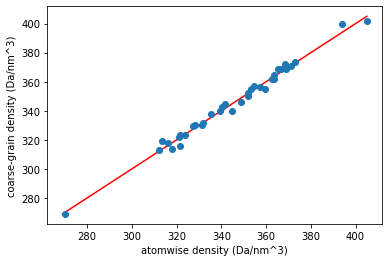

In [16]:
# Make a figure showing the correspondence between the all-atom and coarse grain models.
plt.figure()
ru_minden = np.min([ru_density, ru_density_coarse])
ru_maxden = np.max([ru_density, ru_density_coarse])
plt.plot(np.linspace(ru_minden, ru_maxden), np.linspace(ru_minden, ru_maxden), 'r')
plt.plot(ru_density, ru_density_coarse, 'o')
plt.xlabel("atomwise density (Da/nm^3)")
plt.ylabel("coarse-grain density (Da/nm^3)")
plt.show()